In [31]:
import numpy as np
from astroplan import Observer, FixedTarget
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astroquery.simbad import Simbad
from datetime import datetime, timedelta
from pytz import timezone

In [32]:
# Query Object's coordinates from SIMBAD
objname = "Algol"
Simbad.add_votable_fields("V")
obj = Simbad.query_object(objname)
ra = obj["ra"][0]
dec = obj["dec"][0]
obj_coord = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))
obj_target = FixedTarget(name=objname, coord=obj_coord)

In [33]:
# Observer Location (TIFR, Mumbai)
lon = "72d48m56s"
lat = "18d54m50s"
elevation = 15 * u.m
location = EarthLocation.from_geodetic(lon, lat, elevation)

observer = Observer(name="TIFR Rooftop Telescope", 
                    location=location,
                    timezone=timezone("Asia/Kolkata"))

In [34]:
# Define observation date in IST
date_ist = "2025-03-20"
ist_tz = timezone("Asia/Kolkata")

In [35]:
# Generate times from 00:00 IST to 23:59 IST
start_time_ist = ist_tz.localize(datetime.strptime(date_ist, "%Y-%m-%d") + timedelta(hours=0))
times_ist = [start_time_ist + timedelta(hours=h) for h in np.arange(0, 24, 0.5)]

# Convert IST times to UTC for Astroplan calculations
times_utc = Time([t.astimezone(timezone("UTC")) for t in times_ist])

# Compute Altitude of Object
altaz_frame = AltAz(obstime=times_utc, location=location)
altaz_vals = obj_target.coord.transform_to(altaz_frame)
altitudes = altaz_vals.alt
airmass_vals = altaz_vals.secz 

# Convert timezone-aware datetime to naive datetime for plotting
times_ist_naive = [t.replace(tzinfo=None) for t in times_ist]

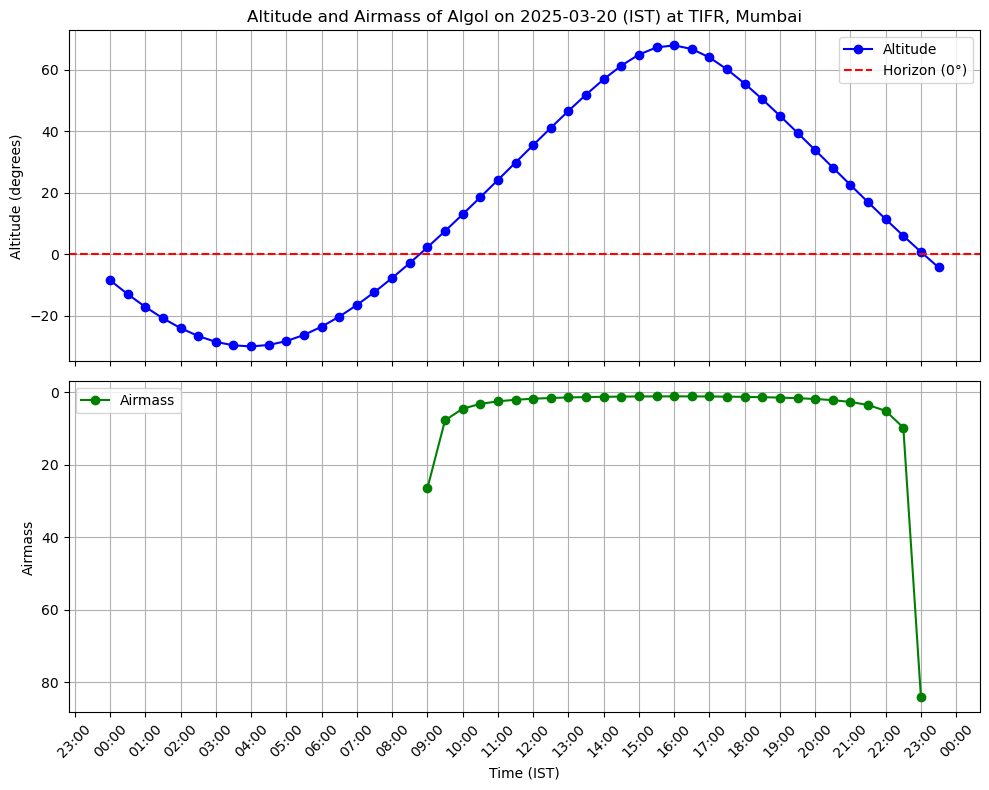

In [36]:
# Plot Altitude and Airmass
airmass_vals[altitudes<0]=np.nan

fig, ax1 = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Altitude Plot
ax1[0].plot(times_ist_naive, altitudes, marker="o", linestyle="-", color="b", label="Altitude")
ax1[0].set_ylabel("Altitude (degrees)")
ax1[0].set_title(f"Altitude and Airmass of {objname} on {date_ist} (IST) at TIFR, Mumbai")
ax1[0].axhline(y=0, color="red", linestyle="--", label="Horizon (0°)")
ax1[0].grid()
ax1[0].legend()

# Airmass Plot
ax1[1].plot(times_ist_naive, airmass_vals, marker="o", linestyle="-", color="g", label="Airmass")
ax1[1].set_ylabel("Airmass")
ax1[1].set_xlabel("Time (IST)")
ax1[1].invert_yaxis()  # Airmass is better shown inverted (lower values at top)
ax1[1].grid()
ax1[1].legend()

# Improve x-axis formatting
ax1[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1[1].xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()